# Hamiltonian NN (HNN) in (q, v) space

- Original code from Y. Chen

- Modified by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True

In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/target_dp_sep_sc.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/input_dp_sep_sc.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi


In [4]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return torch.matmul(gradient[0],St)

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
import time
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  mynet = MLP(input_size,hidden_size,output_size).to(device)
  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=mynet.parameters(),lr=1e-4) #0.001)

  history_loss = []
  history_eval = []
  history_acc = []

  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    mynet.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = mynet.grad(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt

    num_correct = 0
    num_data = 0
    mynet.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = mynet.grad(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)

    if total_loss == np.min(history_loss):
      min_total_loss_in_tl = total_loss
      min_evaluation_loss_in_tl = eval_loss
      min_train_index = epoch+1

    if eval_loss == np.min(history_eval):
      min_evalation_loss_in_el = eval_loss
      min_total_loss_in_el = total_loss
      min_evaluation_index = epoch+1
      path = "./model/danieljh_hnn_dp_sep_sc_2t_lr_{}".format(trial)
      torch.save(mynet.state_dict(), path)
  
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))


2000/2000 training loss:0.00019984324908364214,evaluation loss:0.00020858002462773584
2000/2000 training loss:0.0001774685136297194,evaluation loss:0.0002003697878535604
2000/2000 training loss:0.00017102592341871058,evaluation loss:0.00019397594642214244
2000/2000 training loss:0.00016457323163194816,evaluation loss:0.00020516914373729377
2000/2000 training loss:0.0001661896689711284,evaluation loss:0.00017191233164339791
2000/2000 training loss:0.00020750747580677853,evaluation loss:0.00021387498127296568
2000/2000 training loss:0.00018617794403326117,evaluation loss:0.0001944021205417812
2000/2000 training loss:0.00017864549440673727,evaluation loss:0.0001849906502684462
2000/2000 training loss:0.00019510093752614922,evaluation loss:0.00019001682740054092
2000/2000 training loss:0.00020048324076924474,evaluation loss:0.00020276093655411387
train_loss:0.00018470156792773198, std: 1.4603507774720751e-05
test_loss:0.0001966052750321978, std: 1.1691265186965828e-05
computation_time:1604

In [6]:
import pandas as pd
A = pd.read_csv("./data/A_dp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/B_dp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

In [ ]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

M1, M2, L1, L2, G = m1, m2, l1, l2, g

def Hamiltonian_qv(q1, q2, v1, v2, m1, m2, l1, l2, g):
    """
    Based on the given state vector (q1, q2, v1, v2), 
    computes the total energy (Hamiltonian) of the double-pendulum system.

    Here:
    q1 = theta1 (Angle 1)
    q2 = theta2 (Angle 2)
    v1 = omega1 (Angular Velocity 1)
    v2 = omega2 (Angular Velocity 2)
    """
    theta1 = q1
    theta2 = q2
    omega1 = v1
    omega2 = v2
    
    # --- Kinetic Energy ---  
    T1 = 0.5 * M1 * (L1 * omega1)**2
    T2 = 0.5 * M2 * (
        (L1 * omega1)**2 + 
        (L2 * omega2)**2 + 
        2 * L1 * L2 * omega1 * omega2 * np.cos(theta1 - theta2)
    )
    kinetic_energy = T1 + T2
    
    # --- Potential Energy ---   
    V1 = -M1 * G * L1 * np.cos(theta1)
    V2 = -M2 * G * (L1 * np.cos(theta1) + L2 * np.cos(theta2))
    potential_energy = V1 + V2

    return (kinetic_energy + potential_energy)

(0.01825532, 0.52412613, 0.33688556, 0.20706259)


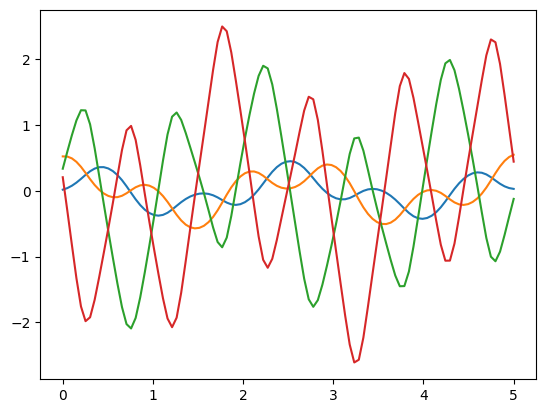

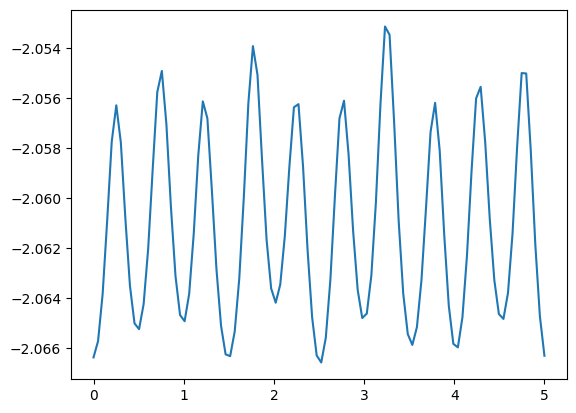

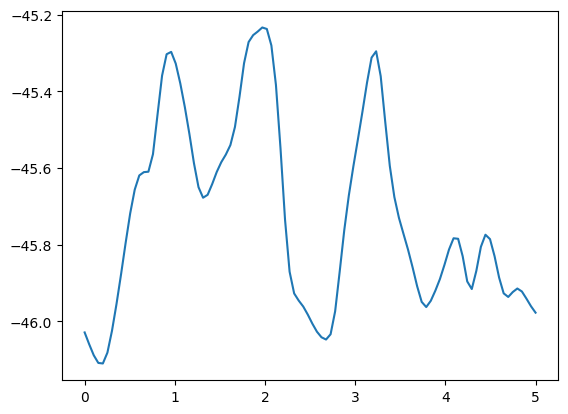

energy shape: (100,)


In [ ]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

trial = 8 #num_trials - 1

input_size = 4
output_size = 1
hidden_size = 200
mynet = MLP(input_size,hidden_size,output_size).to('cpu')
mynet.load_state_dict(torch.load("./model/danieljh_hnn_dp_sep_sc_2t_lr_{}".format(trial), map_location="cpu"))
mynet.eval()

teval = torch.linspace(0.0,5.0,100)

# initial value: (q1, q2, v1, v2)
x0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)

print(x0)
dt = teval[1]-teval[0]
St = torch.tensor(-S, dtype=torch.float32)
teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()
def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,teval)

ax=plt.subplot()
# ax.set_ylim([-3,3])
ax.plot(teval,res[:,0])
ax.plot(teval,res[:,1])
ax.plot(teval,res[:,2])
ax.plot(teval,res[:,3])
  
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

net_energy = net_energy(res, teval).reshape((100))
plt.plot(teval,net_energy)
plt.show()
   
q1 = res[:, 0]
q2 = res[:, 1]
v1 = res[:, 2]
v2 = res[:, 3]

hnn_x = res.copy()  # (M, 4) [q1, q2, v1, v2]

energy = Hamiltonian_qv(q1, q2, v1, v2, m1, m2, l1, l2, g)
plt.plot(teval, energy)
plt.show()

print('energy shape:', energy.shape)

In [ ]:
def mass_matrix_scalar(q1, q2, m1, m2, l1, l2):
    """ 
    Computes M(q) matrix.
    return shape: (2, 2)
    """
    cos12 = np.cos(q1 - q2)
    
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2
    
    return np.array([[M11, M12], [M12, M22]]) # (2, 2)

def mass_matrix_dot_scalar(q1, v1, q2, v2, m1, m2, l1, l2):
    """
    Computes M_dot(q, v), the time derivative of mass-matrix M(q).
    v1, v2: time derivative of q1, q2 (Angular Velocity)
    return shape: (2, 2)
    """
    sin12 = np.sin(q1 - q2)
    
    delta_v = v1 - v2

    M_dot11 = 0.0 # M11 is a constant
    M_dot12 = -m2 * l1 * l2 * sin12 * delta_v
    M_dot22 = 0.0 # M22 is a constant

    return np.array([[M_dot11, M_dot12], [M_dot12, M_dot22]]) # (2, 2)

In [ ]:
# equations of motion (q, v space)
def func(t, state):
  """
  ODE of the double-pendulum system (q, v space)
  state = [q1, q2, v1, v2]
  dvdt = [v1, v2, a1, a2]
  """
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  
  # dq/dt = v
  dvdt[0] = state[2] # v1
  dvdt[1] = state[3] # v2
  
  # dv/dt = a (acceleration)
  # a1
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  # a2
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval-t_eval

# initial values: (q1, q2, v1, v2)
state_init = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state_init.append(s)

# Orbit or trajectory computation
for i in range(1):
  sol = solver(func, [0, tend], state_init[i], t_eval=t_eval)
  tval = sol['t']
  
# plot in (q, v)
q1 = sol['y'][0, :]
q2 = sol['y'][1, :]
v1 = sol['y'][2, :]
v2 = sol['y'][3, :]

true_x = sol['y'].T # (M, 4) [q1, q2, v1, v2]

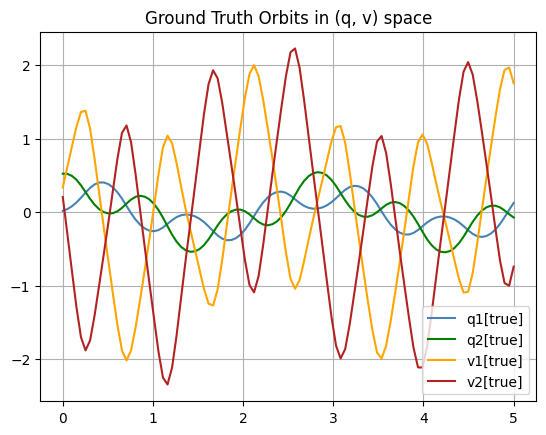

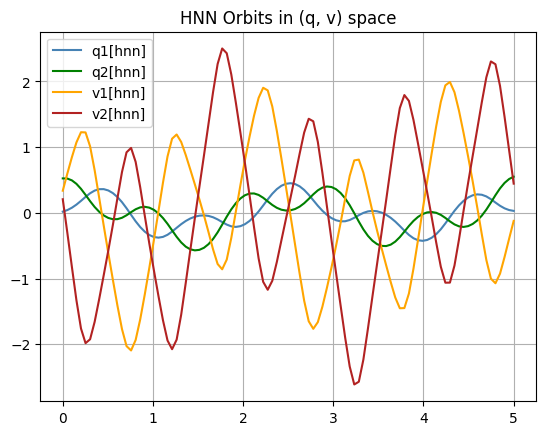

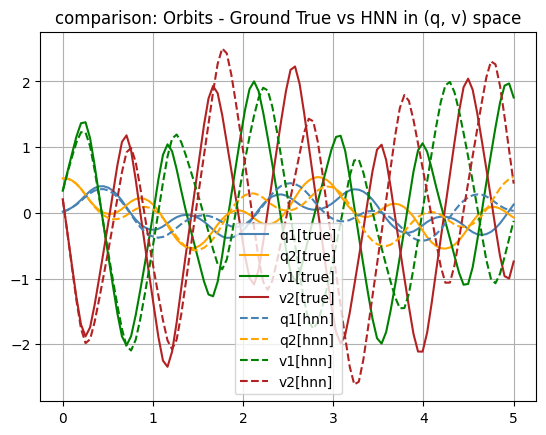

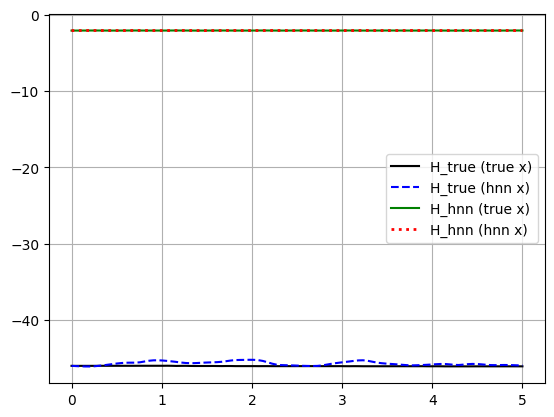

In [ ]:
# HNN orbit in (q, v) space
plt.title("Ground Truth Orbits in (q, v) space")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'orange', label='v1[true]', linestyle='-')
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("HNN Orbits in (q, v) space")
plt.plot(tval, hnn_x[:,0], 'steelblue', label='q1[hnn]', linestyle='-')
plt.plot(tval, hnn_x[:,1], 'g', label='q2[hnn]', linestyle='-')
plt.plot(tval, hnn_x[:,2], 'orange', label='v1[hnn]', linestyle='-')
plt.plot(tval, hnn_x[:,3], 'firebrick', label='v2[hnn]',linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground True vs HNN in (q, v) space")
plt.plot(tval, true_x[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x[:,1], 'orange', label='q2[true]', linestyle='-')
plt.plot(tval, true_x[:,2], 'g', label='v1[true]', linestyle='-') 
plt.plot(tval, true_x[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.plot(tval, hnn_x[:,0], 'steelblue', label='q1[hnn]', linestyle='--')
plt.plot(tval, hnn_x[:,1], 'orange', label='q2[hnn]', linestyle='--')
plt.plot(tval, hnn_x[:,2], 'g', label='v1[hnn]', linestyle='--')
plt.plot(tval, hnn_x[:,3], 'firebrick', label='v2[hnn]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

teval = torch.linspace(0.0,5.0,100)

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

hnn_energy_hnn_x = net_energy(hnn_x, teval).reshape((100))
hnn_energy_true_x = net_energy(true_x, teval).reshape((100))

true_energy_hnn_x = Hamiltonian_qv(hnn_x[:,0], hnn_x[:,1], hnn_x[:,2], hnn_x[:,3], m1, m2, l1, l2, g)
true_energy_true_x = Hamiltonian_qv(true_x[:,0], true_x[:,1], true_x[:,2], true_x[:,3], m1, m2, l1, l2, g)

plt.plot(tval,true_energy_true_x, label='H_true (true x)', color='k', linestyle='-')
plt.plot(tval,true_energy_hnn_x, label='H_true (hnn x)', color='b',linestyle='--')
plt.plot(tval,hnn_energy_true_x, label='H_hnn (true x)', color='g', linestyle='-', lw=1.5)
plt.plot(tval,hnn_energy_hnn_x, label='H_hnn (hnn x)', color='r', linestyle=':', lw=2)
plt.legend()
plt.grid(True)
plt.show()